start training
(2284, 240, 320, 3)
(2284, 60, 80)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
115/115 [==============================] - 18s 114ms/step - loss: 6.3737 - accuracy: 0.0123 - val_loss: 6.0682 - val_accuracy: 0.0128
Epoch 2/50
115/115 [==============================] - 13s 113ms/step - loss: 6.3735 - accuracy: 0.0125 - val_loss: 6.0681 - val_accuracy: 0.0128
Epoch 3/50
115/115 [==============================] - 13s 113ms/step - loss: 6.3732 - accuracy: 0.0123 - val_loss: 6.0679 - val_accuracy: 0.0128
Epoch 4/50
115/115 [==============================] - 13s 112ms/step - loss: 6.3730 - accuracy: 0.0127 - val_loss: 6.0678 - val_accuracy: 0.0127
Epoch 5/50
115/115 [==============================] - 13s 111ms/step - loss: 6.3728 - accuracy: 0.0126 - val_loss: 6.0676 - val_accuracy: 0.0128
Epoch 6/50
115/115 [==============================] - 13s 112ms/step - loss: 6.3725 - accuracy: 0.0127 - val_loss: 6.0674 - val_accuracy: 0.0128
Epoch 7/50
115/115 [==============================] - 12s 108ms/step - loss: 6.3723 - accuracy: 0.0123 - val_loss: 6.0672 - val_ac

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()


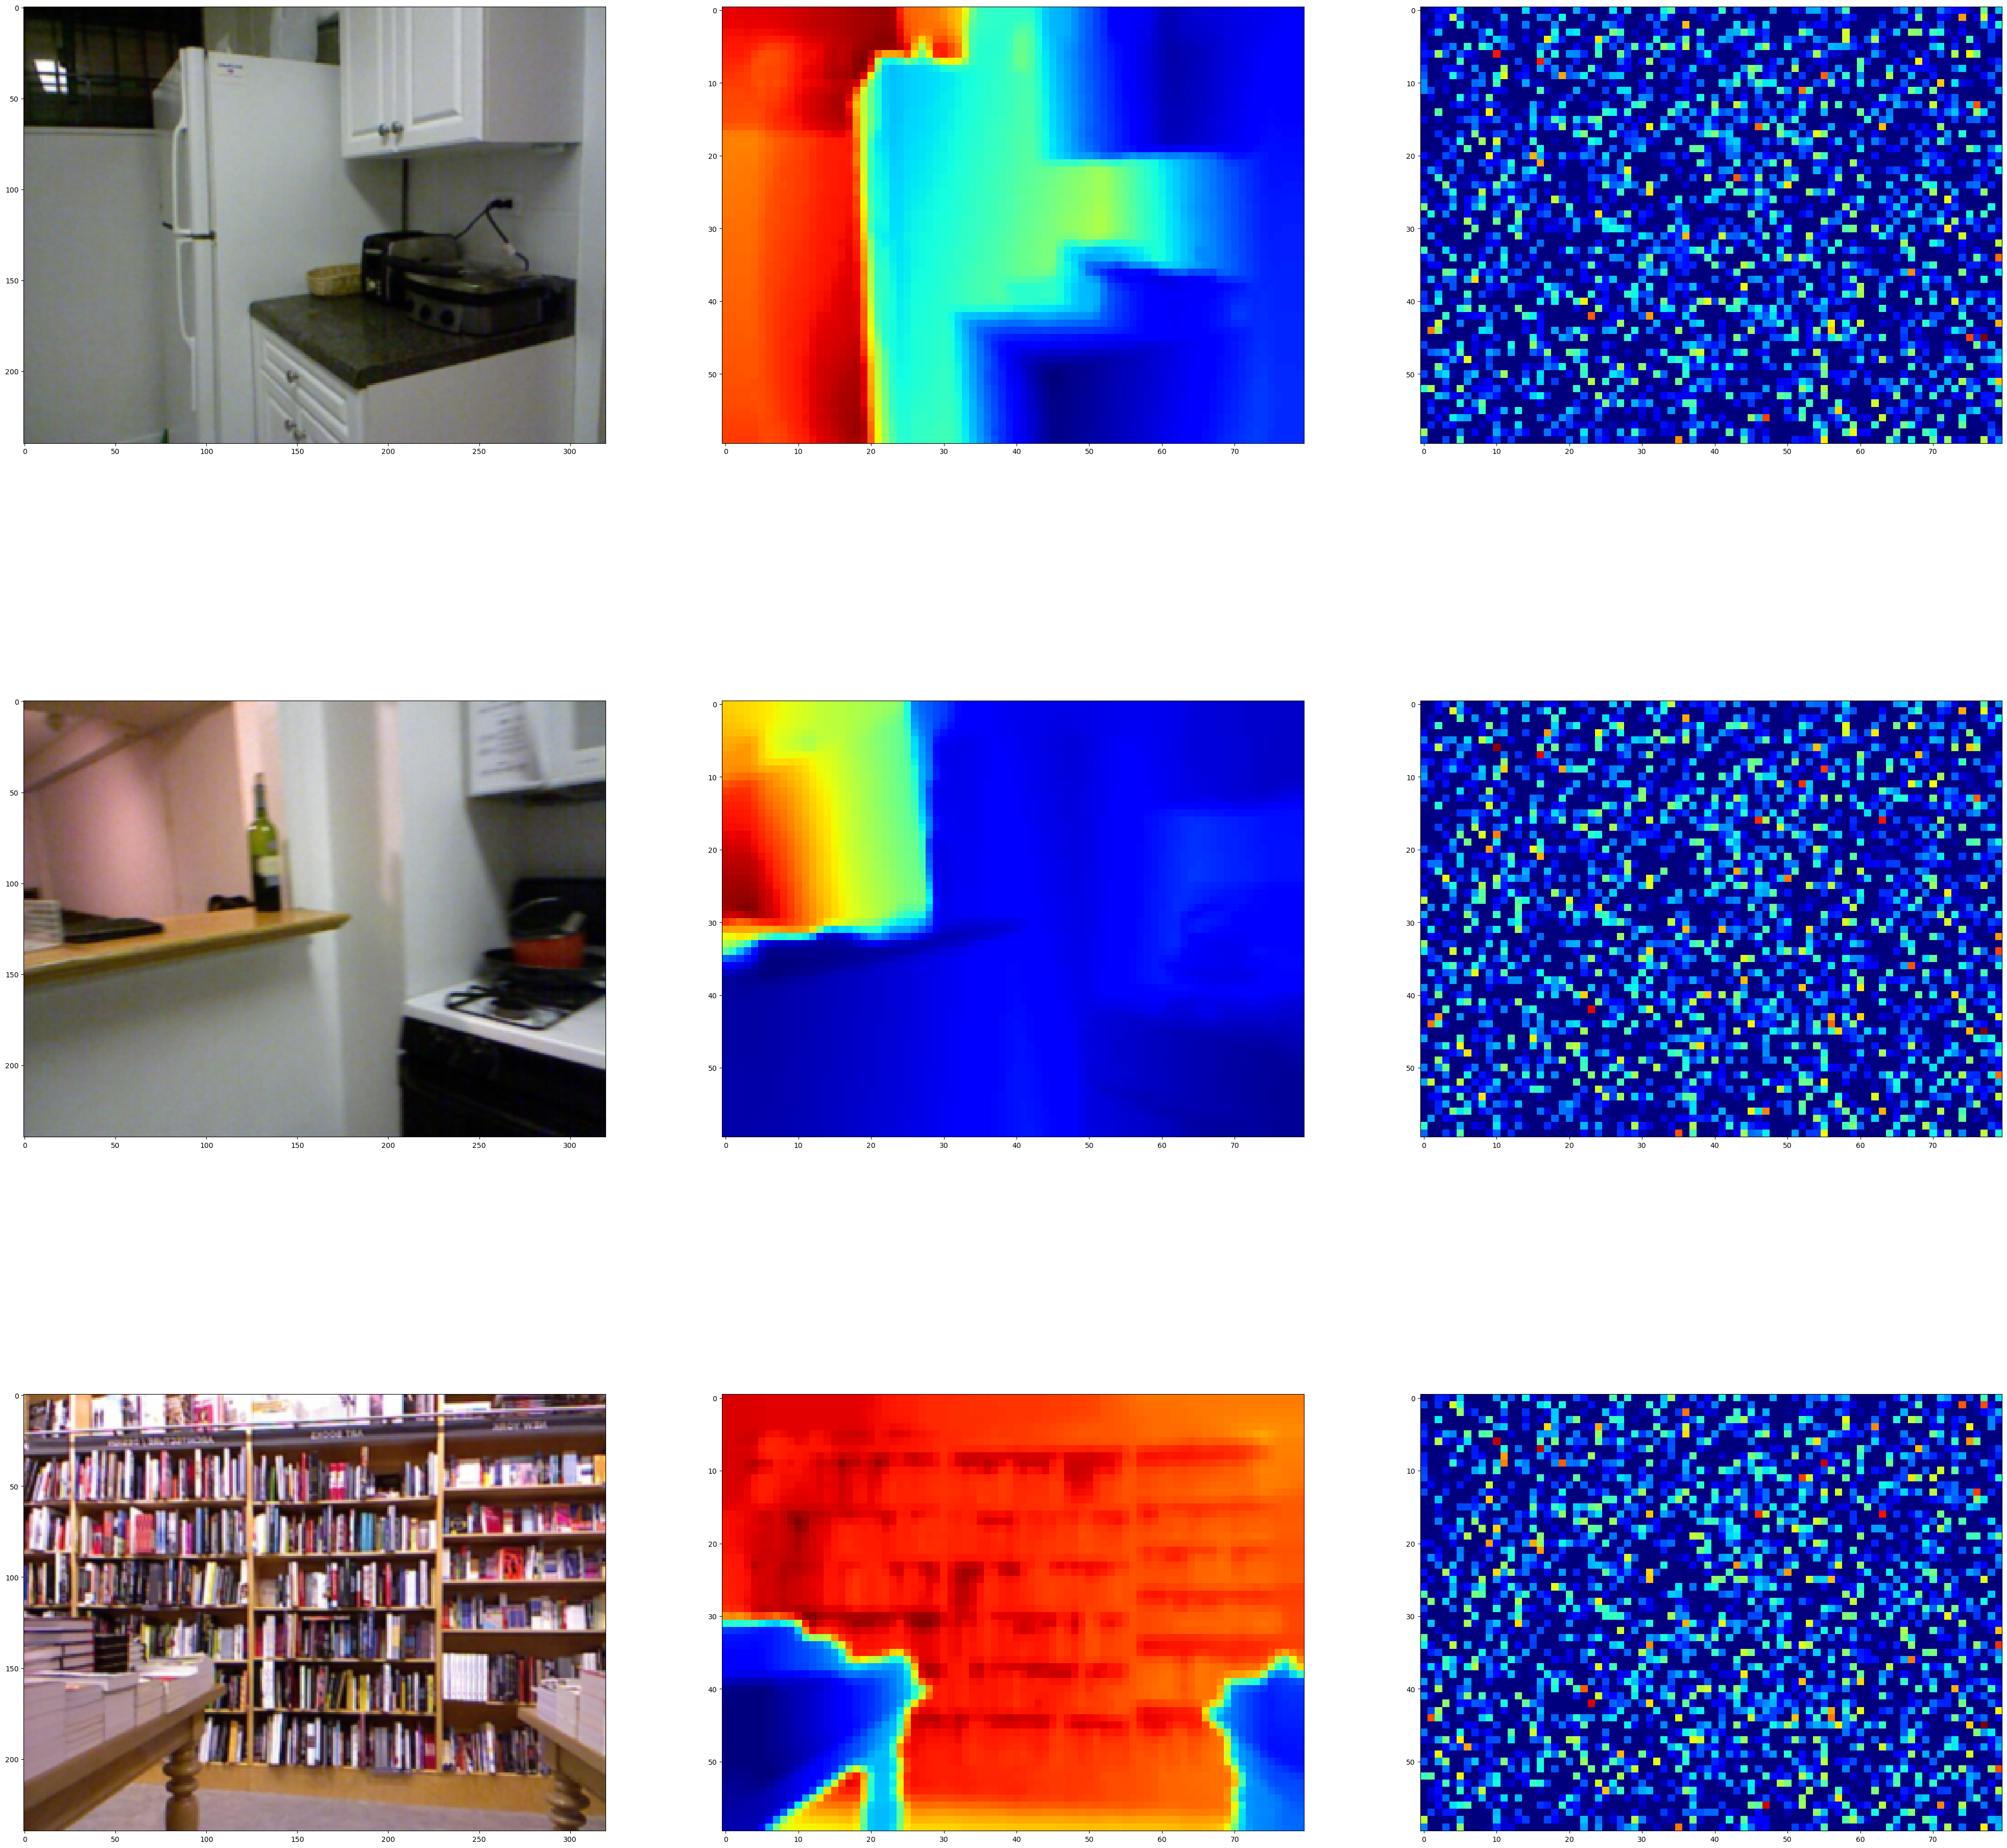

visualized


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


import tensorflow.keras as keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import os
import matplotlib.pyplot as plt
import sklearn
import cv2
import numpy as np

# (2284, 320, 240, 3)
# (2284, 640, 480)
# (2284, 640, 480)

def import_data():
    npzfile = np.load('/kaggle/input/nyu-depth-v1/input_data.npy')
    data_depth = npzfile['x']
    data_images = npzfile['y']
    return data_depth,data_images
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'



# (2284, 320, 240, 3)
# (2284, 640, 480)
# (2284, 640, 480)
lambda_ = 0
cutoff = 2284

def coarse_nn(X,Y):
    print(X.shape)
    print(Y.shape)

    model = keras.models.Sequential() 
    
    # input was downsampled from the original by a factor of 2
    model.add(keras.layers.InputLayer(input_shape=(240,320,3)))
    model.add(keras.layers.Conv2D(96,(11,11),strides = (4,4),activation= 'relu',input_shape =(240,320,1),padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
    model.add(keras.layers.Conv2D(256,(5,5),activation= 'relu',padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
    model.add(keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same'))
    model.add(keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same'))
    model.add(keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(4096,activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(4800,activation='relu')) # output at 1/4 resolution of input
    model.add(keras.layers.Reshape((60,80)))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001),loss = Scale_invariant_loss,metrics = ['accuracy'])
    model.fit(x = X,y = Y, epochs = 50,batch_size = 16, validation_split=0.2)
    #coarse_output = model.predict(X)
    #model.save("my_coarse_model")
    print("Model Saved")
    return model

def Scale_invariant_loss(y_true, y_pred):
    #tf.print("\ny_true",y_true.shape)
    #tf.print("y_pred",y_pred.shape)
    
    #y_pred = tf.clip_by_value(y_pred,0,y_pred.dtype.max)
    #tf.print("y_pred_max",keras.backend.max(y_pred))
    #tf.print("y_pred_min",keras.backend.min(y_pred))
    #log_y_true = keras.backend.log(y_true+keras.backend.epsilon())
    #log_y_pred = keras.backend.log(y_pred+keras.backend.epsilon())

    diff = y_pred - y_true  
    #tf.print("diff_max",keras.backend.max(diff))
    #tf.print("diff_min",keras.backend.min(diff))
    n = y_true.shape[1] * y_true.shape[2]
    
    squared_diff = keras.backend.square(diff)
    #tf.print("squared_diff_max",keras.backend.max(squared_diff))
    #tf.print("squared_diff_min",keras.backend.min(squared_diff))
    
    loss_term1 = tf.math.reduce_mean(squared_diff,[1,2])
    #tf.print("loss_term1",loss_term1.shape)
    #tf.print("loss_term1_max",keras.backend.max(loss_term1))
    #tf.print("loss_term1_min",keras.backend.min(loss_term1))
    
    loss_term2 = tf.math.reduce_sum(diff,[1,2])
    #tf.print("Reduced_sum",loss_term2)
    loss_term2 = keras.backend.square(loss_term2)
    #tf.print("Reduced_sum_squared",loss_term2)

    loss_term2 = 0.5*loss_term2/(n**2)
    #tf.print("loss_term2",loss_term2.shape)
    #tf.print("loss_term2_max",keras.backend.max(loss_term2))
    #tf.print("loss_term2_min",keras.backend.min(loss_term2))
    
    loss = loss_term1 - loss_term2
    #tf.print("per_sample_loss",loss)
    loss = tf.math.reduce_mean(loss)
    #tf.print("total_loss_mean",loss)
    return loss



def load_coarse():
    model = keras.models.load_model("my_coarse_model", compile = False)
    return model

def visualize_depth_map(samples):
    image, target,pred = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")


    fig, ax = plt.subplots(3, 3, figsize=(50, 50))
    for i in range(3):
        
        
        ax[i, 0].imshow((image[i*10].squeeze()))
        ax[i, 1].imshow((target[i*10].squeeze()), cmap=cmap)
        ax[i, 2].imshow((pred[i*10].squeeze()), cmap=cmap)
    plt.show()


def model_predict(model,X):
    y = model.predict(X)
    print(X.shape)
    print(y.shape)
    return y

def plot_coarse(coarse_model,data_depth,data_images):
    #coarse_model = load_coarse()
    print("start predicting")

    coarse_prediction = model_predict(coarse_model,data_images)
    print("coarse_prediction -",coarse_prediction[0])
    print("Data_depth -",data_depth[0])
    visualize_depth_map((data_images,data_depth,coarse_prediction))
    print("visualized")

    return

def main():
    data_depth,data_images = import_data()
    data_depth,data_images = sklearn.utils.shuffle(data_depth,data_images)
    data_images = np.divide(data_images, 255)
    data_images = np.array([cv2.rotate(i,cv2.ROTATE_90_CLOCKWISE) for i in data_images])
    data_depth = np.array([cv2.rotate(i,cv2.ROTATE_90_CLOCKWISE) for i in data_depth])
    
    print("start training")
    coarse_model = coarse_output = coarse_nn(data_images,data_depth)
    print("start plotting")
    plot_coarse(coarse_model,data_depth[:100],data_images[:100])
    
    
    return
 
if __name__ == "__main__":
    main()